In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
import sys
from nltk.corpus import stopwords
import nltk
from gensim.models import ldamodel, CoherenceModel
import gensim.corpora
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#from sklearn.decomposition import NMF
#from sklearn.preprocessing import normalize
import re
import string
import spacy
import pickle

# Topic Modeling Jeopardy! Questions  
In this notebook, we perform topic modeling using Latent Dirichlet Allocation (LDA) to analyze the content of Jeopardy! questions and evaluate how they have changed since 1984. 

## Load and clean data

In [142]:
df = pd.read_csv('JEOPARDY_CSV.csv')
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [143]:
df.columns = ['show_id', 'date', 'round', 'category', 'value', 'question', 'answer']

In [144]:
df['value'].replace({'None': '$0'}, inplace=True)

In [145]:
df['value'] = df['value'].apply(lambda x: int(x[1:].replace(',',''))) #remove $ remove comma and convert to int

In [146]:
df['year'] = df['date'].apply(lambda x: int(x[:4]))

In [147]:
df.head()

,show_id,date,round,category,value,question,answer,year
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,2004
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004


In [98]:
df['round'].unique()

array(['Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!', 'Tiebreaker'],
      dtype=object)

# Explore categories   
Jeopardy! questions come with categories assigned in the game. There have been almost 28,000 unique categories used since 1984, and the top 25 most popular are displayed below.   
  
While these categories do summarize some broader aspects of the questions, they often don't correspond directly to the questions' contents. For example, the most popular category of all time, "Before and After", describes the structure of the answer, not the theme of the question. For example, the question '1980 scarefest in which mom & daughter switch bodies one day & are stalked by Jason at Camp Crystal Lake' yields the answer 'Freaky Friday the 13th', such that the 2 movie titles are spliced together to create one "before and after" title.   
  
In our analysis, we aim to cluster all questions by meaning, not by structure. We will use LDA to analyze the questions in a bag-of-words style, ignoring ordering of words and sentence structure. Ideally, the result will be n clusters of questions that relate to each other thematically.

In [11]:
len(df.category.unique())

27995

In [235]:
df.category.value_counts()[:25]

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
U.S. CITIES                339
WORLD GEOGRAPHY            338
BODIES OF WATER            327
ANIMALS                    324
STATE CAPITALS             314
BUSINESS & INDUSTRY        311
ISLANDS                    301
WORLD CAPITALS             300
U.S. GEOGRAPHY             299
RELIGION                   297
SHAKESPEARE                294
OPERA                      294
LANGUAGES                  284
BALLET                     282
TELEVISION                 281
Name: category, dtype: int64

In [20]:
df[df['category']=='BEFORE & AFTER'][['question','answer']].iloc[0].values

array(['1980 scarefest in which mom & daughter switch bodies one day & are stalked by Jason at Camp Crystal Lake',
       'Freaky Friday the 13th'], dtype=object)

# Preprocess text  
Note - variables from this section have been pickled and saved in ./data_1a. This section takes a while to run and users can skip ahead to the section titled "Analyze LDA on Full Corpus" to avoid waiting.

In [21]:
# adapted from https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Stemming
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    all_stopwords = nlp.Defaults.stop_words
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags and token not in all_stopwords])
    return texts_out

In [25]:
# Combine all preprocessing steps into one function
def preprocessing(df):
    # takes df and completes all preprocessing steps (cleaning text, tokenization, lemmatization).
    # returns id2word and corpus
    d = pd.DataFrame(df.question.apply(lambda x: clean_text(x)))
    dw = list(sent_to_words(list(d.question)))
    lemm = lemmatization(dw, allowed_postags=['NOUN', 'VERB']) #select noun and verb
    id2word = gensim.corpora.Dictionary(lemm)
    corpus = [id2word.doc2bow(text) for text in lemm]
    return lemm, id2word, corpus

In [ ]:
df_question = pd.DataFrame(df.question.apply(lambda x: clean_text(x)))
data_words = list(sent_to_words(list(df_question.question)))
questions_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb

In [104]:
filename = './data_1a/questions_lemmatized'
outfile = open(filename,'wb')
pickle.dump(questions_lemmatized,outfile)
outfile.close()

In [27]:
id2word = gensim.corpora.Dictionary(questions_lemmatized)
corpus = [id2word.doc2bow(text) for text in questions_lemmatized]

In [106]:
filename = './data_1a/corpus'
outfile = open(filename,'wb')
pickle.dump(corpus,outfile)
outfile.close()

## Find ideal number of topics  
LDA is an unsupervised algorithm that, like most clustering algorithms, requires the user to input the target k number of clusters to be output. Here we computer the coherence scores for various numbers of topics to find the ideal k for subsequent modeling.

In [23]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
def compute_coherence_values(dictionary, corp, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = ldamodel.LdaModel(corpus=corp, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
# coherence scores for year=1984
one_yr = df[df.year==1984]
lemm, id2word_1984, corpus_1984 = preprocessing(one_yr)
_, coherence_values_1984 = compute_coherence_values(dictionary=id2word_1984, corp=corpus_1984, texts=lemm, start=2, limit=100, step=6)

In [27]:
# coherence scores for year=1994
one_yr = df[df.year==1994]
lemm, id2word_1994, corpus_1994 = preprocessing(one_yr)
_, coherence_values_1994 = compute_coherence_values(dictionary=id2word_1994, corp=corpus_1994, texts=lemm, start=2, limit=100, step=6)

In [28]:
# coherence scores for year=2004
one_yr = df[df.year==2004]
lemm, id2word_2004, corpus_2004 = preprocessing(one_yr)
_, coherence_values_2004 = compute_coherence_values(dictionary=id2word_2004, corp=corpus_2004, texts=lemm, start=2, limit=100, step=6)

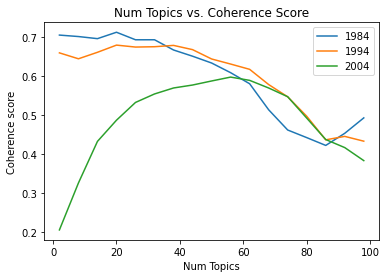

In [29]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_1984, label='1984')
plt.plot(x, coherence_values_1994, label='1994')
plt.plot(x, coherence_values_2004, label='2004')

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Num Topics vs. Coherence Score')
plt.legend()
plt.show()

Based on coherence plots for 1984, 1994, and 2004, it looks like 15-20 topics is a reasonable amount for the full dataset. 

# Run LDA on full dataset

### Generate and save corpus and fitted model

In [28]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=20)

In [29]:
lda.save('./data_1a/lda_trained')

# Analyze LDA on full corpus

### Load saved files

In [99]:
import pickle

In [69]:
filename = './data_1a/corpus'
infile = open(filename,'rb')
corpus = pickle.load(infile)
infile.close()

In [70]:
filename = './data_1a/lda_trained.id2word'
infile = open(filename,'rb')
id2word = pickle.load(infile)
infile.close()

In [71]:
filename = './data_1a/lda_trained'
lda = ldamodel.LdaModel.load(filename)

### Get LDA topics  
The below displays the top 15 words for each of the 20 topics classified by LDA.

In [100]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

get_lda_topics(lda, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,time,use,woman,include,film,s,country,term,know,part,see,city,will,state,island,become,play,hit,go,year
1,one,take,love,serve,title,get,company,mean,word,bird,type,name,find,president,line,capital,crew,tell,be,write
2,die,world,run,way,song,group,have,day,come,animal,work,war,star,author,movie,lead,win,set,put,begin
3,age,character,nickname,turn,feature,form,leave,can,may,name,bear,home,king,story,child,would,show,hear,actor,book
4,art,game,create,food,stand,novel,leader,people,name,open,name,century,give,head,introduce,refer,clue,music,nation,end
5,read,place,member,color,play,base,move,person,letter,share,found,river,help,foot,study,sound,team,record,ship,number
6,site,live,kill,cover,life,could,town,body,call,tree,hold,mile,want,rock,award,should,report,sell,sing,point
7,design,look,wear,order,school,publish,artist,dog,water,join,make,land,series,sign,ride,try,night,ask,say,change
8,visit,name,man,law,house,name,band,name,language,plant,wife,battle,build,sea,office,force,name,do,fire,flag
9,rule,brother,keep,symbol,role,element,meet,describe,follow,version,death,lose,son,family,earth,device,boy,honor,top,inspire


### Topics for document 0 

In [35]:
lda.get_document_topics(corpus[0])

[(4, 0.4975103), (6, 0.17497063), (19, 0.18584527)]

This shows that there is a 49 probability that this document is in topic 4, a 17% probability that it is in topic 6, etc.

### Get best topic for each doc  
df now contains a topic column which can be used for further analysis.

In [102]:
most_likely_topic=[]
for doc in corpus:
    likelihoods = dict(lda.get_document_topics(doc))
    most_likely_topic.append(max(likelihoods,key=likelihoods.get))

In [148]:
df['topic'] = most_likely_topic

In [149]:
df.head()

,show_id,date,round,category,value,question,answer,year,topic
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004,4
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004,2
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,2004,17
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004,16
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004,13


# Analysis of topics between rounds

Here we aim to analyse how topics change between each round of Jeopardy. The trivia game has three rounds: Jeopardy, Double Jeopardy, and Final Jeopardy. Do the topics change between each of the rounds? Are there certain topics you can expect to find in one round but not another? 

In [138]:
dfs= [x for _, x in df.groupby('round')]

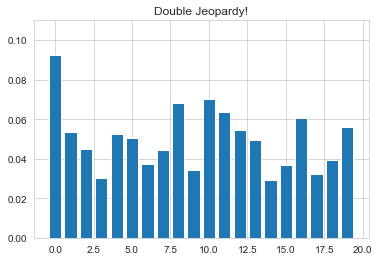

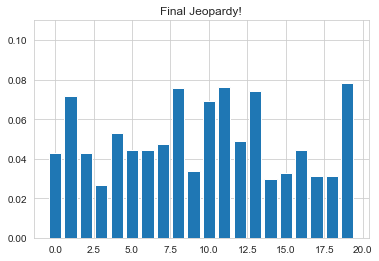

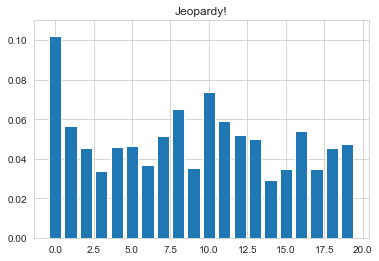

In [150]:
num_topics = len(df['topic'].unique())
top_topics=[]
for d in dfs[:-1]:
    topic_counts = [0]*num_topics
    for topic in d['topic'].copy():
        topic_counts[topic]+=1
    topics_perc = [count/sum(topic_counts) for count in topic_counts]
    plt.bar(range(20), topics_perc)
    plt.title(d['round'].iloc[0])
    plt.ylim(0, 0.11)
    plt.show()
    top_topics.append((-np.array(topics_perc)).argsort()[:5])

The above plots shows the frequency of each topic for each round. When comparing the Jeopardy! and Double Jeopardy! rounds we can see that the distrubtions are similar, which suggests you may most often find questions of similar topics in these rounds. 

In [156]:
top_topics # Double Jeopardy, Final Jeopardy, Jeopardy
pd.DataFrame(top_topics, index = ['Double Jeopardy', 'Final Jeopardy', 'Jeopardy'], columns = [1,2,3,4,5])

,1,2,3,4,5
Double Jeopardy,0,10,8,11,16
Final Jeopardy,19,11,8,13,1
Jeopardy,0,10,8,11,1


Above are the top 5 topics in each of the rounds. Both Double! Jeopardy and Jeopardy! have very similar top topics, while Final Jeopardy! has different topics appear more frequently.

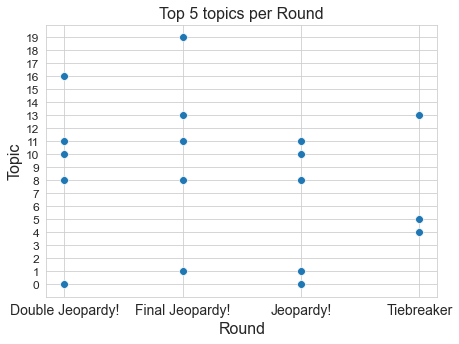

In [159]:
import seaborn as sns
a = df.groupby(['round','topic']).size().to_frame('count').reset_index()
a = a.sort_values(['round','count'], ascending=[True,False])
topk_topics = a.groupby('round').head(5).reset_index()
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(7,5))
sns.scatterplot(x=topk_topics['round'], y=topk_topics['topic'], s=60)
ax.set_title('Top 5 topics per Round', size=16)
ax.set_yticks(range(20))
ax.set_xlabel('Round', size=16)
ax.set_ylabel('Topic', size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.show()

The Jeopardy! and Double Jeopardy! rounds share 4 of their top 5 topics: 0, 8, 10, and 11. This means you can likely expect similar questions in these two rounds most of the time. The Final Jeopardy! round has different top topics than the other rounds, but still shares the top topics 8 and 11. 

Because topics 8 and 11 are so prominent it would be interesting to look at what the topics are about:

In [57]:
common_topics = pd.DataFrame()
topic8 = lda.show_topic(8, topn = 15)
common_topics['topic_8'] = [i[0] for i in topic8]
topic11 = lda.show_topic(11, topn = 15)
common_topics['topic_11'] = [i[0] for i in topic11]
common_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_8,know,word,come,may,name,letter,call,water,language,follow,mean,meaning,phrase,creature,governor
topic_11,city,name,war,home,century,river,mile,land,battle,lose,area,add,lie,capital,father


Topic 8 appears to be related to language and writing. Topic 11 appears to be related to history and war. This is not too suprising as these are topics you would expect in a trivia show. 

The top topic for the Final Jeopardy! round is topic 19. This topic does not appear in the other two rounds. So, if you hope to do well in the Final Jeopardy! round if it best to know this topic!! Topic 19 is related to:

In [58]:
final_topic = pd.DataFrame()
topic19 = lda.show_topic(19, topn = 15)
final_topic['topic_19'] = [i[0] for i in topic19]
final_topic.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_19,year,write,begin,book,end,number,point,change,flag,inspire,sister,director,side,center,novel


Topic 19 appears to be related to literature. So know your literature if you hope to do well in Final Jeopardy! 

# Analysis of Rounds over time  
Now, let's take a look at how these topics have changed over time. 

In [160]:
def plot_distbns(df, k=None):
    """
    plots distribtions
    AND
    return the top k topics for each year
    """
    year_idx = []
    d = {i:[0]*20 for i in range(1984,2013)}
    for i, row in df.iterrows():
        topic = d[row['year']]
        topic[row['topic']]+=1
        d[row['year']] = topic

    #calculating percent of each topic per year
    for year in d:
        d[year] = [count/sum(d[year]) for count in d[year]]
        if k is not None:
            idx = (-np.array(d[year])).argsort()[:k]
            year_idx.append(idx)
    #plotting dibstribnitons   
    fig, axs = plt.subplots(4,7,figsize=(22,12))
    index= 0
    years = list(d.keys())
    for i in range(4):
        for j in range(7):
            axs[i,j].bar(range(20), d[years[index]])
            axs[i,j].set_title(years[index])
            axs[i,j].set_ylim([0.0, 0.14])
            index +=1
    return year_idx

In [172]:
def plot_top_topics(df):
    import seaborn as sns
    a = df.groupby(['year','topic']).size().to_frame('count').reset_index()
    a = a.sort_values(['year','count'], ascending=[True,False])
    topk_topics = a.groupby('year').head(5).reset_index()
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(15,7))

    sns.scatterplot(x=topk_topics['year'], y=topk_topics['topic'], s=60)
    round_name = df['round'].iloc[0]
    ax.set_title('Top 5 topics per Year in {} Round'.format(round_name), size=16)
    ax.set_xticks(range(1984, 2013))
    ax.set_yticks(range(20))
    ax.set_xlabel('Year', size=16)
    ax.set_ylabel('Topic', size=16)
    plt.show()

## Double Jeopardy!

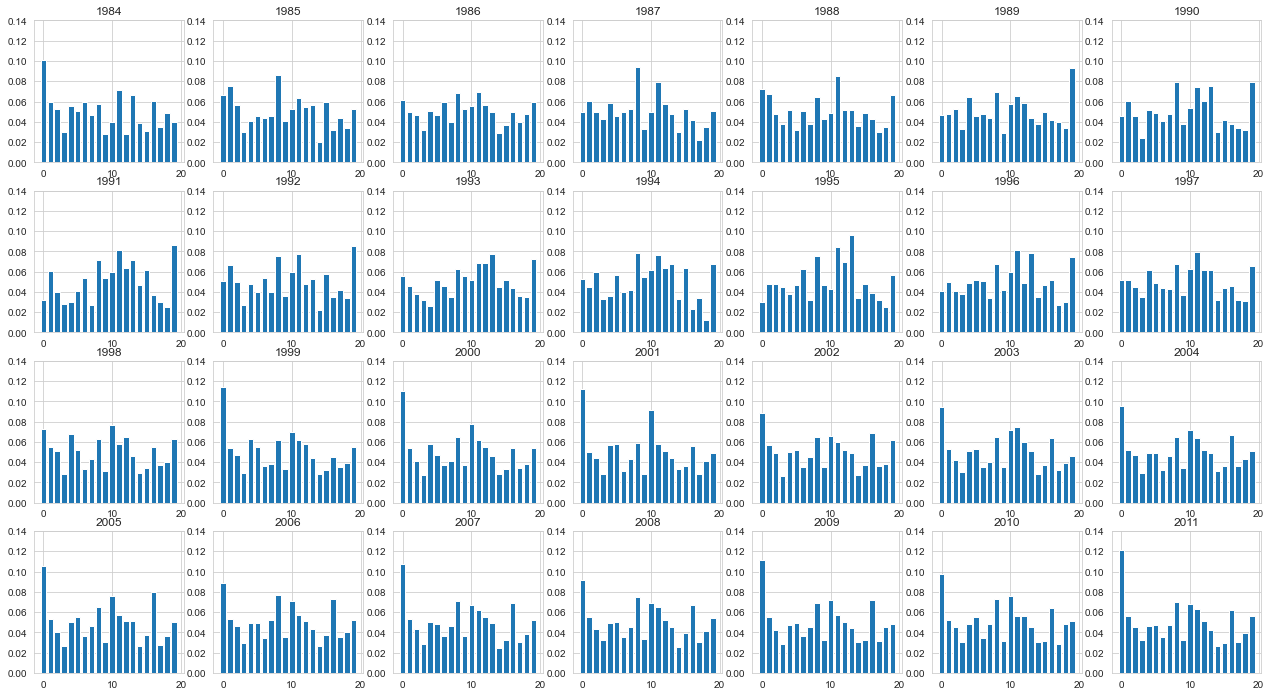

In [162]:
double_idx = plot_distbns(dfs[0],5)

In [171]:
# 5 most common topics each year
pd.DataFrame(double_idx, index = range(1984, 2013), columns = [1,2,3,4,5])

,1,2,3,4,5
1984,0,11,13,16,1
1985,8,1,0,11,15
1986,11,8,0,6,19
1987,8,11,1,4,12
1988,11,0,1,19,8
1989,19,8,11,4,12
1990,19,8,13,11,1
1991,19,11,13,8,12
1992,19,11,8,1,10
1993,13,19,12,11,8


The most common Double Jeopardy topic (0) has been consistent over the last 14 years. After a 9 year drought of that topic in the top five just two years prior, it jumped to the top position and remained there until at least 2012.

The topic words of topic 0 are as follows:

In [210]:
hard_topics = pd.DataFrame()
topic0 = lda.show_topic(0, topn = 15)
hard_topics['topic_0'] = [i[0] for i in topic0]
hard_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_0,time,one,die,age,art,read,site,design,visit,rule,poem,building,store,drink,note


From these words it appear this topic is closely related to the arts. 

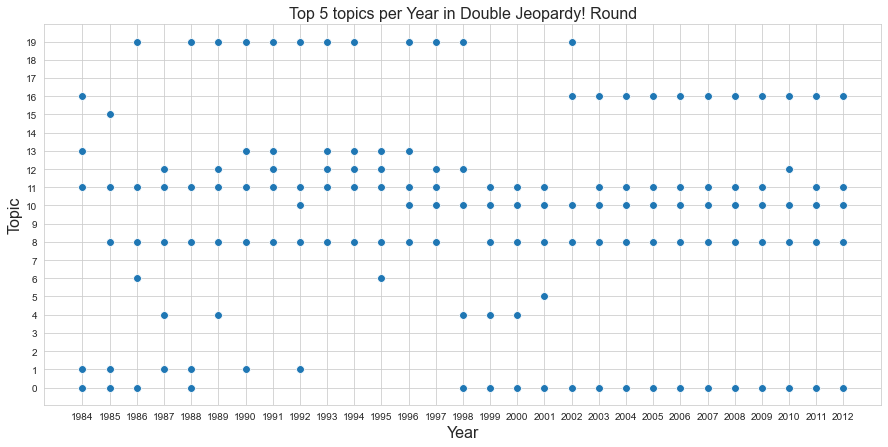

In [205]:
plot_top_topics(dfs[0])

Topic 11 has consistently been in the top 5 topics across all the years. We have seen the words in topic 11 before as it was one of the most common topics across all game rounds. The words seem to be related to history and war.

In [174]:
t11 = pd.DataFrame()
topic11 = lda.show_topic(11, topn = 15)
t11['topic_11'] = [i[0] for i in topic11]
t11.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_11,city,name,war,home,century,river,mile,land,battle,lose,area,add,lie,capital,father


Some topics, like topics 1 and 15, were only used until 1992:

In [176]:
old_topics = pd.DataFrame()
topic1 = lda.show_topic(1, topn = 15)
old_topics['topic_1'] = [i[0] for i in topic1]
topic15 = lda.show_topic(15, topn = 15)
old_topics['topic_15'] = [i[0] for i in topic15]
old_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_1,use,take,world,character,game,place,live,look,name,brother,mother,title,kid,room,today
topic_15,become,capital,lead,would,refer,sound,should,try,force,device,item,name,make,coast,general


Both of these topics look they are related to geopolitical events -- could their decline in popularity be correlated to the end of the Cold War in 1991?

## Final Jeopardy!

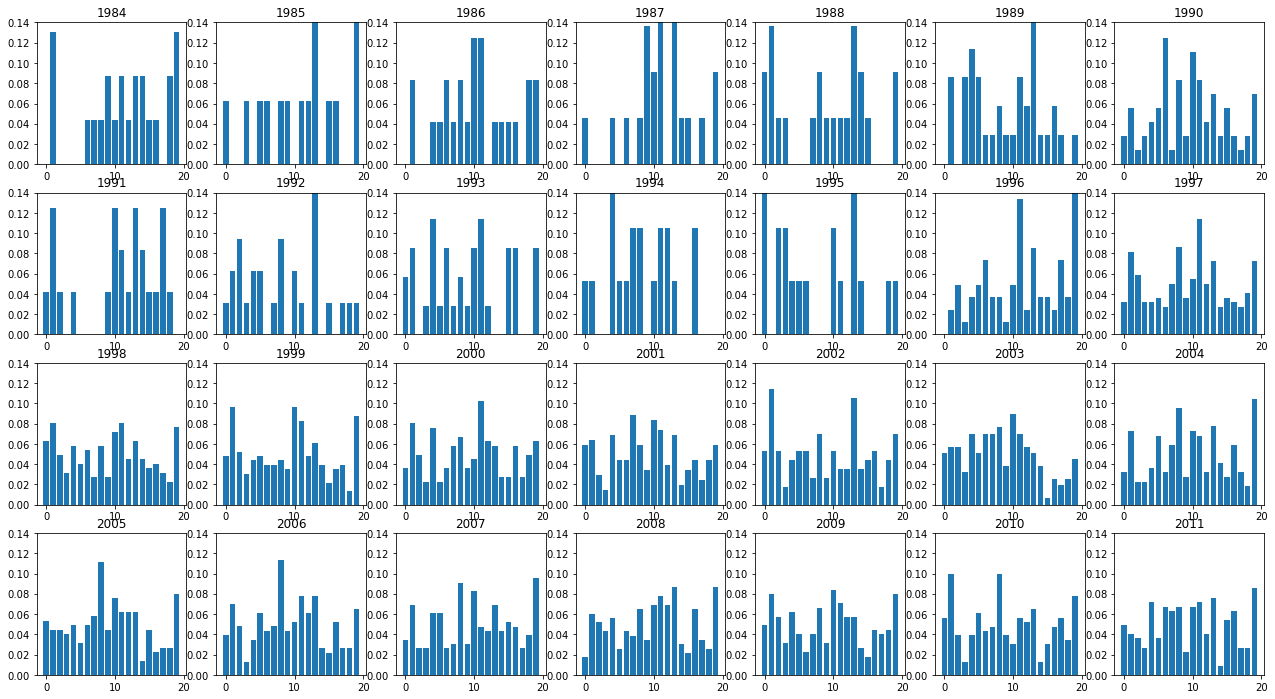

In [162]:
final_idx = plot_distbns(dfs[1], 5)

The first 10 years there was less diversity of topics. The variety of questions were limited to less than 20 topics. The more recent 10 became much more diverse across all topics

In [259]:
# 5 most common topics each year
pd.DataFrame(final_idx, index = range(1984, 2013), columns = [1,2,3,4,5])

,1,2,3,4,5
1984,19,1,14,13,11
1985,19,13,16,15,12
1986,11,10,19,1,6
1987,13,11,9,10,19
1988,1,13,0,14,8
1989,13,4,1,3,5
1990,6,10,8,11,19
1991,1,17,13,10,14
1992,13,2,8,1,4
1993,4,11,19,1,16


The Final Jeopardy round has much more variety of topics each year.

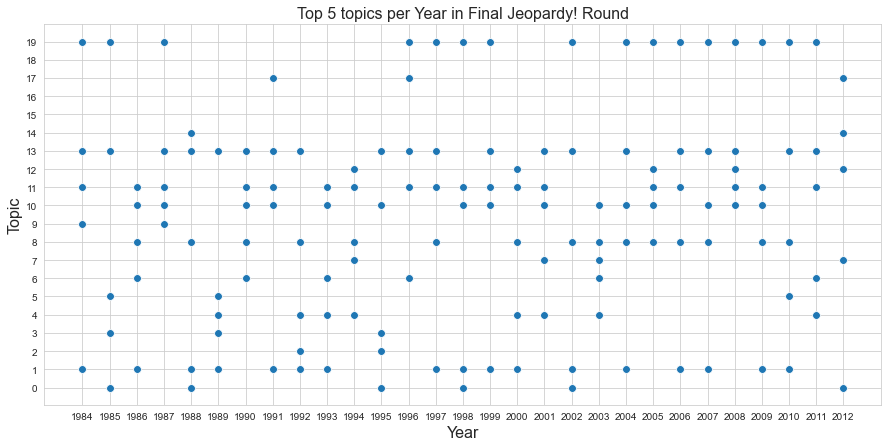

In [195]:
plot_top_topics(dfs[1])

Topic 14 only occured in 2012 and 1988. It would be interesting to see what this topic is.

In [177]:
a = pd.DataFrame()
topic14 = lda.show_topic(14, topn = 15)
a['topic_14'] = [i[0] for i in topic14]
a.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_14,island,line,movie,child,introduce,study,award,ride,office,earth,player,fight,name,heart,hero


This topic appears to be related to movies, perhaps even children's movies.

## Jeopardy!

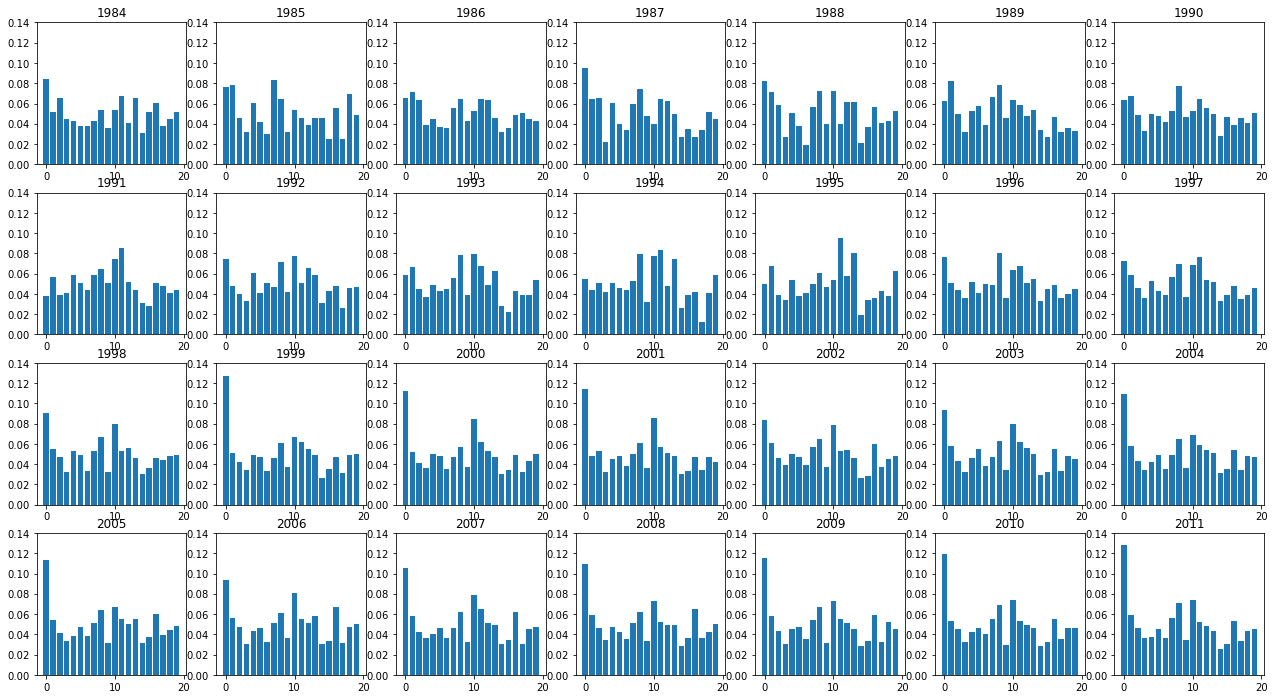

In [165]:
j_idx = plot_distbns(dfs[2], 5)

In [260]:
# 5 most common topics each year
pd.DataFrame(j_idx, index = range(1984, 2013), columns = [1,2,3,4,5])

,1,2,3,4,5
1984,0,11,2,13,16
1985,7,1,0,18,8
1986,1,0,8,11,2
1987,0,8,2,1,11
1988,0,10,8,1,13
1989,1,8,7,10,0
1990,8,1,11,0,12
1991,11,10,8,4,7
1992,10,0,8,12,4
1993,10,8,11,1,13


Question topics have been consistent in recent years. 14 of the last 15 years all have topics 0 and topic 10 as the two most common. 

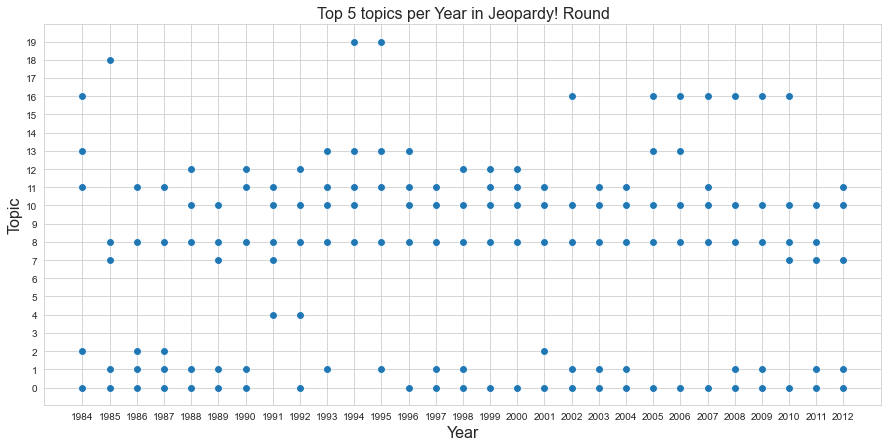

In [196]:
plot_top_topics(dfs[2])

Topics 0, 1, 8, 10, and 11 are consistently in the top 5 topics each year, while topics such as 3, 5, 14, and 17 never appear in the top 5.

Let's take a look at the ever-popular topic 8:

In [178]:
a = pd.DataFrame()
topic8 = lda.show_topic(8, topn = 15)
a['topic_8'] = [i[0] for i in topic8]
a.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_8,know,word,come,may,name,letter,call,water,language,follow,mean,meaning,phrase,creature,governor


Topic 8 appear to be related to language and writing. 

Topic 18 only appeared once in nearly 30 years! Wonder what that topic could be...

In [179]:
a = pd.DataFrame()
topic18 = lda.show_topic(18, topn = 15)
a['topic_18'] = [i[0] for i in topic18]
a.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_18,go,be,put,actor,nation,ship,sing,say,fire,top,let,field,make,send,church


This topic seems to be related to the Navy, with words like 'nation', 'ship', 'sing', 'send', 'fire', etc...

# Part A: Summary of findings
This section analyzed questions between categories and across time. A summary of the results is as follows:

When comparing the topics between the three rounds of Jeopardy! (Jeopardy!, Double Jeopardy!, and Final Jeopardy!) we found that the most common topics used in the Jeopardy! and Double Jeopardy! rounds are almost the same. In their top 5 topics they shared four which were 0, 8, 10, 11. This means you can most likely expect similar topics in these two rounds.  The Final Jeopardy! round's most common topics were different, but did still included topics 8 and 11. Topic 8 seemed to be related to writing and language, while topics 11 seemed to be related to history and war. So the take away from this is knowing topics 8 and 11 can be very useful if you want to do well across all the rounds. On the other hand, if you want to do well particularly in the Final Jeopardy! round is would be very helpful to know topic 19, which is related to literature. 

When looking at the Jeopardy! round over time we saw that of the 15 most recent years, 14 of them had the same top 2 topic (0 and 10). This means the topics of questions you most often would see in this round have not changed in over a decade. Topics 0, 1, 8, 10, and 11 are consistently in the top 5 topics each year, while topics such as 3, 5, 14, and 17 never appear in the top 5.

We see something similar in the Double Jeopardy! round. Each of the past 14 years' top topics were the same, topic 0. This comes just two years after a 9 year streak of topic 0 not being in top 5 most common topic at all. Topic 0 seems to be related to the arts. 

In the Final Jeopardy! round, during the 1980s and 1990s most of the questions were limited to a few topics. There were several topics in which no question was asked in those earlier years. In more recent years, the diversity of the topics increased, and the top 5 topics consistently change each year. Topics 15, 16, and 17 never appear in the top 5 topics. Topic 18 appeared once in nearly 30 years!

# Part 2: Analyzing topics by dollar value of questions

## Split df by value  
Here we split the data into groups based on question value. The analytical goal is to analyze the difficulty of questions across years by dollar value of each question. Therefore, it's important to only include values where the dollar value represents the difficulty of the question and ignore values like daily doubles and final jeopardy where the player determines the value of their response. Since the values on the board have changed over the years, we can't necessarily use the divisible-by-100 pattern that's used on Jeopardy today. Instead, we have taken \\$2000 as the maximum point value and binned all lower values into groups of \\$200.

In [180]:
# only take rows from Jeopardy and Double Jeopardy
df_ = df.loc[(df['round'] == 'Jeopardy!') | (df['round'] == 'Double Jeopardy!')]

# only takes values <= $2000
df_ = df_[df_['value']<=2000]
df_ = df_.sort_values('value')

# bin dollar values into groups of every $200
bins =  np.arange(0, 18000, 200)
ind = np.digitize(df_['value'], bins)

# assign group label to each dollar value 
df_['value_group'] = ind

## Plot Range of values for all topics  
Here, we plot the unique values for each topic. The colors represent the non-LDA, actual question categories that were listed on the game board. 

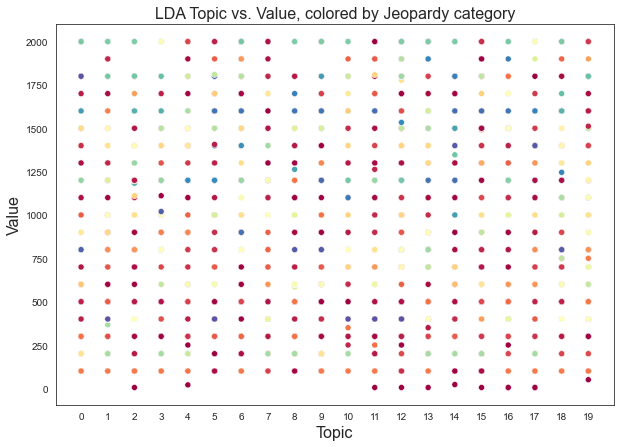

In [181]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x=df_['topic'],y=df_['value'], hue=df_['category'], palette='Spectral', legend=False)
ax.set_xticks(range(20))
ax.set_xlabel('Topic', size=16)
ax.set_ylabel('Value', size=16)
ax.set_title('LDA Topic vs. Value, colored by Jeopardy category', size=16)
plt.show()

It appears that pretty much every topic appears with every value at least once. There does not seem to be a relationship between the LDA topics and the Jeopardy! categories, or the colors would be arranged in vertical stripes along the x-axis.

## Plot top 5 topics for each monetary value

In [311]:
a = df_.groupby(['value_group','topic']).size().to_frame('count').reset_index()
a = a.sort_values(['value_group','count'], ascending=[True,False])
topk_topics = a.groupby('value_group').head(5).reset_index()

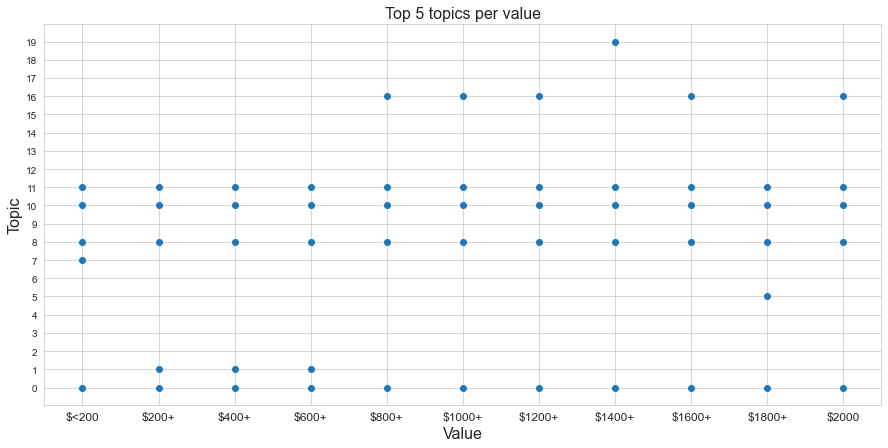

In [312]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,7))
bins = ['$<200', '$200+', '$400+', '$600+', '$800+', '$1000+',\
 '$1200+', '$1400+', '$1600+', '$1800+', '$2000']
sns.scatterplot(x=topk_topics['value_group'], y=topk_topics['topic'], s=60)
ax.set_title('Top 5 topics per value', size=16)
ax.set_xticks(range(1,12))
ax.set_xticklabels(bins, size=12)
ax.set_yticks(range(20))
ax.set_xlabel('Value', size=16)
ax.set_ylabel('Topic', size=16)
plt.show()

It looks like the top 5 topics are mostly the same for each value bin, but there are a few topics (16, 19, and 5) that only appear in more valuable, or "harder" questions. Let's take a look at the words in those 2 topics.

In [313]:
hard_topics = pd.DataFrame()

In [319]:
topic16 = lda.show_topic(16, topn = 15)
hard_topics['topic_16'] = [i[0] for i in topic16]
topic19 = lda.show_topic(19, topn = 15)
hard_topics['topic_19'] = [i[0] for i in topic19]
topic5 = lda.show_topic(5, topn = 15)
hard_topics['topic_5'] = [i[0] for i in topic5
hard_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_16,play,crew,win,show,clue,team,report,night,name,boy,host,latin,actress,break,accord
topic_19,year,write,begin,book,end,number,point,change,flag,inspire,sister,director,side,center,novel
topic_5,get,group,form,novel,base,could,publish,name,element,guy,receive,call,cross,treat,object


Topic 16 apprease to be sports related, topic 19 appears to be book or story related. There doesn't appear to be a clear pattern with topic 5, but it does contain some words that might have to do with complex literature or science-related questions.

On the other hand, topics 1 and 7 only appear in lower-value questions:

In [317]:
easy_topics = pd.DataFrame()
topic1 = lda.show_topic(1, topn = 15)
easy_topics['topic_1'] = [i[0] for i in topic1]
topic7 = lda.show_topic(7, topn = 15)
easy_topics['topic_7'] = [i[0] for i in topic7]
easy_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_1,use,take,world,character,game,place,live,look,name,brother,mother,title,kid,room,today
topic_7,term,mean,day,can,people,person,body,dog,name,describe,car,eye,speak,month,brand


These topics definitely have simpler words than the "hard" topics, with topic 1 containing words to do with families and homes, and topic 7 having basic descriptive terms about people and animals.

## Plot top 5 monetary values for each topic

In [176]:
b = a.sort_values(['topic','count'], ascending=[True,False])
topk_values = b.groupby('topic').head(5).reset_index()

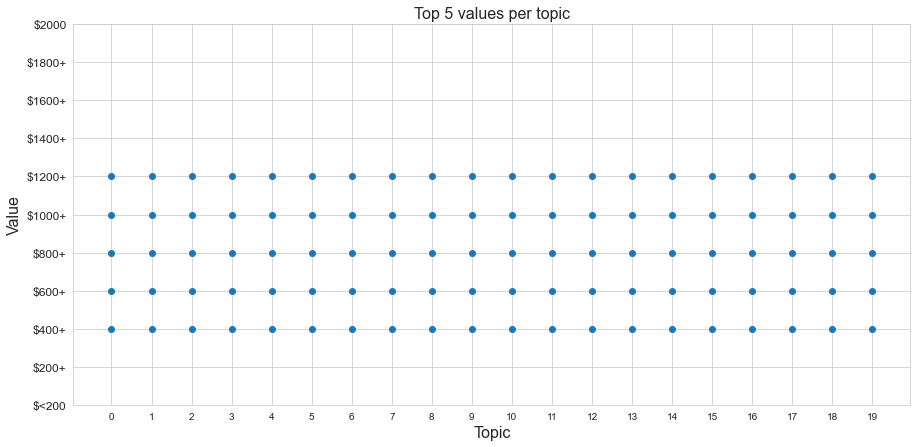

In [272]:
fig, ax = plt.subplots(figsize=(15,7))
bins = ['$<200', '$200+', '$400+', '$600+', '$800+', '$1000+',\
 '$1200+', '$1400+', '$1600+', '$1800+', '$2000']
sns.scatterplot(x=topk_values['topic'], y=topk_values['value_group'], s=60)
ax.set_title('Top 5 values per topic', size=16)
ax.set_xticks(range(20))
ax.set_yticks(range(11))
ax.set_yticklabels(bins, size=12)
ax.set_xlabel('Topic', size=16)
ax.set_ylabel('Value', size=16)
plt.show()

Each topic has the same top 5 values. This suggests that the same 5 values are most common in Jeopardy! overall.

From looking at the topics split by value, we see some patterns, particularly in the top 5 topics per value. The same 4 topics, 0, 8, 10, and 11, are consistently represented across all dollar value groups. These are also among the most popular topics across rounds and years as identified in part 1. There are also some topics that are mostly reserved for easier (5, 9, and 16) or harder questions (1, 7). 

Next, let's split each of these groups by year and see how difficulty has changed over time.